**Using CNN model for Stock Price movement Prediction**

In [42]:
import pandas as pd
from sympy.printing.tensorflow import tensorflow
from tensorflow.python.keras.activations import leaky_relu


def map_to_labels(x, window_size=10):
    """
    Normalize input data and map to labels for each sliding window:
    - (1-k, k) if less than the mean.
    - (k, 1-k) if greater than the mean.
    
    Parameters:
        x (np.ndarray): Input data of shape (n,).
        window_size (int): Size of the sliding window.
    
    Returns:
        np.ndarray: Labels of shape (num_windows, window_size, 2).
    """
    # Step 1: Apply sliding window
    windows = np.lib.stride_tricks.sliding_window_view(x, window_shape=window_size)[::window_size]
    
    # print(windows.shape)
    
    # Step 2: Normalize the data within each window
    data_min = np.min(windows, axis=1, keepdims=True)
    data_max = np.max(windows, axis=1, keepdims=True)
    # normalized_data = (windows - data_min) / (data_max - data_min)  # Min-max normalization
    normalized_data = windows

    mean = np.mean(normalized_data, axis=1, keepdims=True)
    variance = np.var(normalized_data,axis=1,keepdims=True)
    sigma = np.sqrt(variance)

    k = np.exp(-((normalized_data - mean) ** 2) / (2 * sigma**2)) / 2
    # Step 5: Map labels
    labels = np.zeros((windows.shape[0], windows.shape[1], 2))  # Shape: (num_windows, window_size, 2)
    greater_mask = normalized_data >= mean  # Boolean mask for values > mean

    # Apply label mapping
    labels[greater_mask, 0] = 1-k[greater_mask]
    labels[greater_mask, 1] = k[greater_mask]
    labels[~greater_mask, 0] = k[~greater_mask]
    labels[~greater_mask, 1] = 1-k[~greater_mask]

    return labels[:,:,1]


In [43]:
import utils
# data = utils.process_stock_data("AAPL","max","1d")

# stocks = ["AAPL","MSFT","GOOGL","AMZN","TSLA","META","NVDA","PYPL","INTC","NFLX"]
stocks = ["AAPL","NVDA"]
# stocks = 

data = pd.DataFrame()
for s in stocks:
    data = pd.concat([data,utils.process_stock_data(s,"max","1d")])
data = data.dropna()

data = data[data["Date"].str.split("-").str[0].astype(int) >= 2015]
data = data.drop(columns=["Date","Volume"])
# std scale 
data = (data - data.mean())/data.std()
data = data.dropna()
# data = data[["Close","RSI"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5072 entries, 8587 to 6545
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5072 non-null   float64
 1   High    5072 non-null   float64
 2   Low     5072 non-null   float64
 3   Close   5072 non-null   float64
 4   SMA_10  5072 non-null   float64
 5   SMA_50  5072 non-null   float64
 6   RSI     5072 non-null   float64
dtypes: float64(7)
memory usage: 317.0 KB


In [44]:
import numpy as np
seq = 10
y_seq = 1
n = len(data.columns)
# X_for_p = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq+y_seq,n))[::y_seq]
# X_for_p = np.reshape(X_for_p,(X_for_p.shape[0],X_for_p.shape[2],X_for_p.shape[3]))
# y = np.array([map_to_labels(x[:,3].flatten(),window_size=seq+y_seq) for x in X_for_p])
# y = np.reshape(y,(y.shape[0],y.shape[2]))
# y = y[:,-y_seq:]

X = np.lib.stride_tricks.sliding_window_view(data.values, window_shape=(seq,n))[::y_seq][:-1]
X = np.reshape(X,(X.shape[0],X.shape[2],X.shape[3]))
# X = X[:,:,3]
y = np.lib.stride_tricks.sliding_window_view(data["Close"].values, window_shape=(y_seq))[seq::y_seq]
# print(X.shape,y.shape)
y = (y[:, -1] > X[:, 0,0]).astype(int).reshape(-1, 1)
# print(target_output.shape)
X_1 = X[0:2592]
y_1 = y[0:2592]
X_2 = X[2592:]
y_2 = y[2592:]
X=X_1
y=y_1
#std normalization
# X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
# y = (y - np.mean(y))/np.std(y)
split_size = 0.2
split = int(len(X)*split_size)
X_train = X[:-split]
X_test = X[-split:]
y_train = y[:-split]
y_test = y[-split:]


In [45]:
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
# scaler = MinMaxScaler()
# data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
data.head()


,Open,High,Low,Close,SMA_10,SMA_50,RSI
8587,-0.523606,-0.528707,-0.532285,-0.530926,-0.518359,-0.508842,-0.673725
8588,-0.534332,-0.538259,-0.539067,-0.541575,-0.520580,-0.508580,-0.813498
8589,-0.540387,-0.542435,-0.541795,-0.541541,-0.522496,-0.508447,-0.633027
8590,-0.538104,-0.539799,-0.534557,-0.536389,-0.524298,-0.508235,-0.210885
8591,-0.531080,-0.526277,-0.527565,-0.522075,-0.524523,-0.507723,-0.024782


In [46]:
# Display dataset information
print(data.info())

# Summary statistics of numerical columns
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 5072 entries, 8587 to 6545
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5072 non-null   float64
 1   High    5072 non-null   float64
 2   Low     5072 non-null   float64
 3   Close   5072 non-null   float64
 4   SMA_10  5072 non-null   float64
 5   SMA_50  5072 non-null   float64
 6   RSI     5072 non-null   float64
dtypes: float64(7)
memory usage: 317.0 KB
None
               Open          High           Low         Close        SMA_10  \
count  5.072000e+03  5.072000e+03  5.072000e+03  5.072000e+03  5.072000e+03   
mean   8.965839e-17  1.793168e-16  1.344876e-16 -4.482919e-17  4.482919e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -9.018134e-01 -9.030179e-01 -9.004670e-01 -9.018057e-01 -9.004622e-01   
25%   -8.081348e-01 -8.087967e-01 -8.068074e-01 -8.072531e-01 -8.069117e-01   
50%   -4.643264e-01 -4.669591e-01 -4.63741

In [63]:
from tensorflow.keras import layers, models
from tensorflow.nn import leaky_relu as lr

# Step 1: Define the Conv1D model
def build_conv1d_stock_model(input_size=100, output_size=10):
    """
    Build a Conv1D model for predicting binary probabilities for the next steps.
    Each output corresponds to the probability of going up (1) for each of the next 10 steps.
    """
    model = models.Sequential([
        layers.Input(shape=(input_size, n)),  # Input: (100, 1)
        layers.Conv1D(filters=128, kernel_size=5, activation=lr, padding='same'),
        layers.Dropout(0.2),  # Dropout added after convolution

        layers.MaxPooling1D(pool_size=3),
        layers.Conv1D(filters=256, kernel_size=5, activation=lr, padding='same'),
        layers.Dropout(0.2),  # Dropout added after convolution

        layers.Flatten(),
        layers.Dropout(0.2),  # Dropout added after convolution

        layers.Dense(128, activation=lr),
        layers.Dense(output_size, activation='sigmoid')  # Output binary probabilities for 10 steps
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Create the model
model = build_conv1d_stock_model(input_size=seq, output_size=1)
model.summary()

# Step 3: Train the model
history = model.fit(
    X_train, y_train,  # y_train should have shape (num_samples, 10, 1)
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32
)

# Step 4: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 10, 128)        │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,265 (1.02 MB)

 Trainable params: 267,265 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7277 - loss: 0.5272 - val_accuracy: 0.7529 - val_loss: 0.4757
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8273 - loss: 0.3996 - val_accuracy: 0.8050 - val_loss: 0.4155
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8332 - loss: 0.3759 - val_accuracy: 0.7741 - val_loss: 0.4853
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8229 - loss: 0.3798 - val_accuracy: 0.6815 - val_loss: 0.6589
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8356 - loss: 0.3723 - val_accuracy: 0.7645 - val_loss: 0.4532
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8463 - loss: 0.3580 - val_accuracy: 0.8069 - val_loss: 0.3978
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8375 - loss: 0.3638 - val_accuracy: 0.8282 - val_loss: 0.3878
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8447 - loss: 0.3529 - val_accuracy: 0.8417 - val_

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2470, 1)


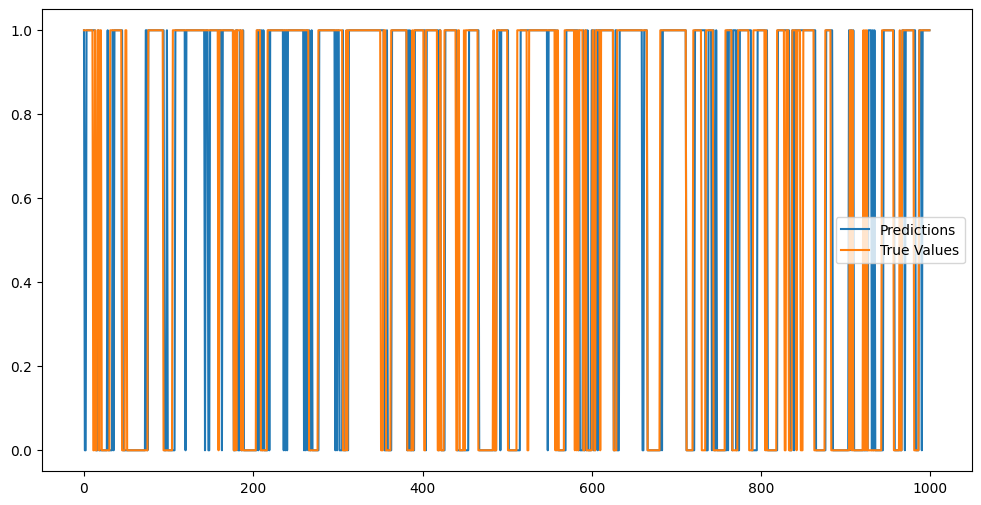

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       383
           1       0.83      0.87      0.85       617

    accuracy                           0.81      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.81      0.80      1000



In [64]:


_x = X_2
_y = y_2

predictions = model.predict(_x)  # Predict for the first 5 test samples
predictions = (predictions > 0.5).astype(int)
print(predictions.shape)
#min max scale predicitons
# predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
predictions = predictions.flatten()
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
t= 1000
plt.plot(predictions[0:t], label='Predictions')
plt.plot(_y.flatten()[0:t], label='True Values')
plt.legend()
plt.show()
#classfication report
from sklearn.metrics import classification_report
report = classification_report(predictions[0:t],_y.flatten()[0:t])
print(report)

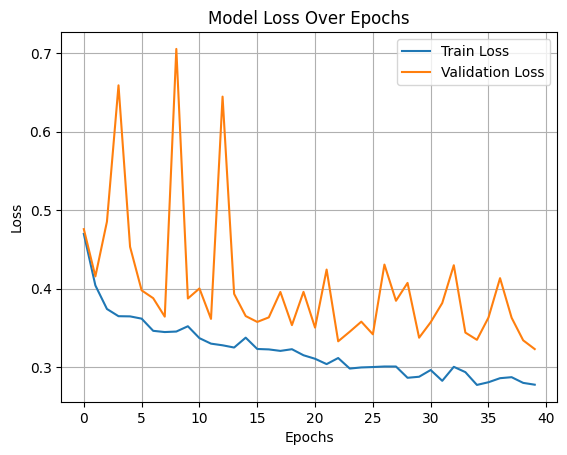

In [65]:
# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()